In [695]:
import pandas as pd
import numpy as np
from numba import jit
from alpaca.data.historical import StockHistoricalDataClient
from alpaca.data.requests import StockBarsRequest
from alpaca.trading import TradingClient
from alpaca.trading.requests import GetCalendarRequest
from alpaca.data.timeframe import TimeFrame
from alpaca.data.enums import Adjustment

from typing import List, Tuple, Optional, Dict

import matplotlib.pyplot as plt
from collections import defaultdict, deque
import numpy as np
import toml
import os
import math

from datetime import datetime, timedelta, time
from zoneinfo import ZoneInfo
from tqdm import tqdm

# Importing the modules themselves for reloading
import TradePosition
import TouchArea
import TradingStrategy

# Reloading the modules to apply any changes
import importlib
importlib.reload(TradePosition)
importlib.reload(TouchArea)
importlib.reload(TradingStrategy)

from TradePosition import TradePosition, export_trades_to_csv, plot_cumulative_pnl_and_price
from TouchArea import TouchArea, TouchAreaCollection
from TradingStrategy import StrategyParameters, TouchDetectionAreas, TradingStrategy 


from dotenv import load_dotenv

ny_tz = ZoneInfo("America/New_York")
STANDARD_DATETIME_STR = '%Y-%m-%d %H:%M:%S'
ROUNDING_DECIMAL_PLACES = 10  # Choose an appropriate number of decimal places

load_dotenv(override=True)
livepaper = os.getenv('LIVEPAPER')
config = toml.load('../config.toml')

# Replace with your Alpaca API credentials
API_KEY = config[livepaper]['key']
API_SECRET = config[livepaper]['secret']


trading_client = TradingClient(API_KEY, API_SECRET)

In [620]:

def is_security_shortable_and_etb(symbol: str) -> bool:
    asset = trading_client.get_asset(symbol)
    return asset.shortable and asset.easy_to_borrow

# # Example usage
# print(is_security_shortable_and_etb('AAPL'))
# print(is_security_shortable_and_etb('TSLA'))
# print(is_security_shortable_and_etb('GME'))
# print(is_security_shortable_and_etb('BMY'))


In [621]:
def is_security_marginable(symbol: str) -> bool:
    try:
        asset = trading_client.get_asset(symbol)
        return asset.marginable
    except Exception as e:
        print(f"Error checking marginability for {symbol}: {e}")
        return False
    
# # testing purposes
# def is_security_marginable(symbol: str) -> bool:
#     marginable_symbols = {'NVDA', 'MSFT', 'AAPL', 'TJX', 'JNJ', 'AMZN', 'TSLA', 'AZN'}
#     return symbol in marginable_symbols

# for symbol in {'NVDA', 'MSFT', 'AAPL', 'TJX', 'JNJ', 'AMZN', 'TSLA', 'AZN'}:
#     print(symbol, is_security_marginable(symbol))

In [622]:
def get_market_hours(dates: List[datetime.date]) -> Dict[datetime.date, Tuple[datetime, datetime]]:
    """
    Parameters:
    dates (list of str): List of dates in 'YYYY-MM-DD' format.

    Returns:
    
    dict: Dictionary with dates as keys and (market_open, market_close) tuples as values.
    """
    start_date = min(dates)
    end_date = max(dates)
    
    calendar_request = GetCalendarRequest(start=start_date, end=end_date)
    calendar = trading_client.get_calendar(calendar_request)
    
    # market_hours = {str(day.date): (day.open.replace(tzinfo=ny_tz), day.close.replace(tzinfo=ny_tz)) for day in calendar}
    market_hours = {day.date: (day.open.astimezone(ny_tz), day.close.astimezone(ny_tz)) for day in calendar}
    return market_hours

In [623]:
def calculate_dynamic_levels(df:pd.DataFrame, ema_short=9, ema_long=20):
    """
    Calculate VWAP and EMAs for the dataframe.
    
    :param df: DataFrame with 'close', 'high', 'low', and 'volume' columns
    :param ema_short: Period for the short EMA (default 9)
    :param ema_long: Period for the long EMA (default 20)
    :return: DataFrame with additional columns for VWAP and EMAs
    """
    
    assert 'vwap' in df.columns
    
    # Calculate EMAs
    # df[f'EMA{ema_short}'] = df['close'].ewm(span=ema_short, adjust=False).mean()
    # df[f'EMA{ema_long}'] = df['close'].ewm(span=ema_long, adjust=False).mean()
    
    # Calculate a combined central value
    # df['central_value'] = (df['vwap'] + df[f'EMA{ema_short}'] + df[f'EMA{ema_long}']) / 3
    # df['central_value'] = df['vwap']
    # df['central_value'] = df[f'EMA{ema_short}']
    # df['central_value'] = df[f'EMA{ema_long}']
    
    # 1
    # df['central_value'] = df['close'].ewm(span=26, adjust=True).mean()
    
    # 2
    # df['central_value'] = df['close'].ewm(span=26, adjust=False).mean()
    
    # 3
    # halflife = '26min'  # 26 minutes
    # df['central_value'] = df['close'].ewm(
    #     halflife=halflife,
    #     times=df.index.get_level_values('timestamp'),
    #     adjust=True
    # ).mean()

    # #4
    # span = 26 # span of 26 = 9.006468342000588min
    # alpha = 2 / (span + 1)
    # halflife = np.log(2) / np.log(1 / (1 - alpha))
    # halflife_str = f"{halflife}min"

    # df['central_value'] = df['close'].ewm(
    #     halflife=halflife_str,
    #     times=df.index.get_level_values('timestamp'),
    #     adjust=True
    # ).mean()
    
    #45
    span = 26 # span of 26 = 9.006468342000588min
    alpha = 2 / (span + 1)
    halflife = np.log(2) / np.log(1 / (1 - alpha))
    halflife_str = f"{halflife}min"

    df['central_value'] = df['close'].ewm(
        halflife=halflife_str,
        times=df.index.get_level_values('timestamp'),
        adjust=True
    ).mean()
    df['central_value'] = (df['vwap'] + df['central_value']*2) / 3

In [624]:
def fill_missing_data(df):
    # Step 1: Create a complete range of timestamps
    full_idx = pd.date_range(start=df.index.get_level_values('timestamp').min(), 
                             end=df.index.get_level_values('timestamp').max(), 
                             freq='min', 
                             tz=df.index.get_level_values('timestamp').tz)

    # Step 2: Reindex the DataFrame
    df = df.reindex(pd.MultiIndex.from_product([df.index.get_level_values('symbol').unique(), full_idx], 
                                               names=['symbol', 'timestamp']))

    # Step 3: Forward-fill OHLC values using ffill()
    df[['open', 'high', 'low', 'close']] = df[['open', 'high', 'low', 'close']].ffill()

    # Step 4: Fill volume and trade_count with 0
    df['volume'] = df['volume'].fillna(0)
    df['trade_count'] = df['trade_count'].fillna(0)

    # VWAP remains NaN where missing
    
    return df


In [625]:
@jit(nopython=True)
def process_touches(touches, prices, touch_area_lower, touch_area_upper, level, level_lower_bound, level_upper_bound, is_long, min_touches):
    consecutive_touches = np.full(min_touches, -1, dtype=np.int64)
    count = 0
    prev_price = None
    for i in range(len(prices)):
        price = prices[i]
        is_touch = (prev_price is not None and 
                    ((prev_price < level <= price) or (prev_price > level >= price)) or 
                    (price == level))
        
        if level_lower_bound <= price <= level_upper_bound:
            if is_touch:
                consecutive_touches[count] = touches[i]
                count += 1
                if count == min_touches:
                    return consecutive_touches
        else:
            buy_price = touch_area_upper if is_long else touch_area_lower
            if (is_long and price > buy_price) or (not is_long and price < buy_price):
                consecutive_touches[:] = -1
                count = 0
        
        prev_price = price
    return np.empty(0, dtype=np.int64)  # Return empty array instead of empty list

def calculate_touch_area(levels_by_date, is_long, df, symbol, market_hours, min_touches, bid_buffer_pct, use_median, touch_area_width_agg, multiplier, start_time, end_time):
    touch_areas = []
    widths = []

    for date, levels in tqdm(levels_by_date.items()):
        current_id = 0
        market_open, market_close = market_hours.get(date, (None, None))
        if market_open and market_close:
            date_obj = pd.Timestamp(date).tz_localize(ny_tz)
            if start_time:
                day_start_time = date_obj.replace(hour=start_time.hour, minute=start_time.minute)
            else:
                day_start_time = market_open
            if end_time:
                day_end_time = min(date_obj.replace(hour=end_time.hour, minute=end_time.minute), market_close - pd.Timedelta(minutes=3))
            else:
                day_end_time = market_close - pd.Timedelta(minutes=3)
                
        else:
            # print('Hours not available. Skipping',date)
            continue
        
        day_data = df[df.index.get_level_values('timestamp').date == date]
        day_timestamps = day_data.index.get_level_values('timestamp')
        day_timestamps_np = day_timestamps.astype(np.int64)  # Convert to nanoseconds
        day_prices = day_data['close'].values
        day_atr = day_data['MTR' if use_median else 'ATR'].values

        for (level_lower_bound, level_upper_bound, level), touches in levels.items():
            if len(touches) < min_touches:
                continue
            
            touch_timestamps_np = np.array([t.timestamp() * 1e9 for t in touches], dtype=np.int64)  # Convert to nanoseconds
            touch_indices = np.searchsorted(day_timestamps_np, touch_timestamps_np)
            
            touch_area_width = touch_area_width_agg(day_atr[touch_indices]) * multiplier

            if touch_area_width is None or np.isnan(touch_area_width) or touch_area_width <= 0:
                continue
            
            widths.append(touch_area_width)
            
            # SUBJECt TO CHANGE
            touch_area_lower = level - (2 * touch_area_width / 3) if is_long else level - (1 * touch_area_width / 3)
            touch_area_upper = level + (1 * touch_area_width / 3) if is_long else level + (2 * touch_area_width / 3)
            
            # touch_area_lower = level - (1 * touch_area_width / 3) if is_long else level - (2 * touch_area_width / 3)
            # touch_area_upper = level + (2 * touch_area_width / 3) if is_long else level + (1 * touch_area_width / 3)
            
            # touch_area_lower = level - (1 * touch_area_width / 2) if is_long else level - (1 * touch_area_width / 2)
            # touch_area_upper = level + (1 * touch_area_width / 2) if is_long else level + (1 * touch_area_width / 2)
            
            
            valid_mask = (day_timestamps[touch_indices] >= day_start_time) & (day_timestamps[touch_indices] < day_end_time)
            # valid_mask = (day_timestamps[touch_indices] < day_end_time)
            
            valid_touch_indices = touch_indices[valid_mask]
            valid_prices = day_prices[valid_touch_indices]
            
            consecutive_touch_indices = process_touches(
                valid_touch_indices, 
                valid_prices,
                touch_area_lower, 
                touch_area_upper,  
                level, 
                level_lower_bound,
                level_upper_bound, 
                is_long, 
                min_touches
            )
            
            if len(consecutive_touch_indices) == min_touches:
                consecutive_touches = day_timestamps[consecutive_touch_indices[consecutive_touch_indices != -1]]
                touch_area = TouchArea(
                    date=date,
                    id=current_id,
                    level=level,
                    upper_bound=touch_area_upper,
                    lower_bound=touch_area_lower,
                    touches=consecutive_touches,
                    is_long=is_long,
                    min_touches=min_touches,
                    bid_buffer_pct=bid_buffer_pct
                )
                touch_areas.append(touch_area)
                current_id += 1

    return touch_areas, widths

In [626]:
from dataclasses import dataclass
from typing import Optional, Callable

# symbol, start_date, end_date, atr_period=15, level1_period=5, multiplier: float=2, min_touches=2, bid_buffer_pct: float=0.005, start_time=None, end_time=None, use_median=False, \
#     touch_area_width_agg=np.median, use_saved_bars=False, export_bars_path=None):
    
@dataclass
class TouchDetectionParameters:
    symbol: str
    start_date: str
    end_date: str
    atr_period: int = 15
    level1_period: int = 15
    multiplier: float = 2.0
    min_touches: int = 3
    bid_buffer_pct: float = 0.005
    start_time: Optional[str] = None
    end_time: Optional[str] = None
    use_median: bool = False
    touch_area_width_agg: Callable = np.median
    use_saved_bars: bool = False
    export_bars_path: Optional[str] = None

def calculate_touch_detection_area(params: TouchDetectionParameters):
    """
    Calculates touch detection areas for a given stock symbol based on historical price data and volatility.

    Parameters:
    params (TouchDetectionParameters): An instance of TouchDetectionParameters containing all necessary parameters.

    Returns:
    dict: A dictionary containing:
        - 'symbol': The analyzed stock symbol
        - 'long_touch_area': List of TouchArea objects for long positions
        - 'short_touch_area': List of TouchArea objects for short positions
        - 'market_hours': Dictionary of market hours for each trading day
        - 'bars': DataFrame of price data
        - 'mask': Boolean mask for filtering data
        - 'bid_buffer_pct': The bid buffer percentage used
        - 'min_touches': The minimum number of touches used
        - 'start_time': The start time used for analysis
        - 'end_time': The end time used for analysis
        - 'use_median': Whether median was used instead of mean

    This function analyzes historical price data to identify significant price levels (support and resistance)
    based on the frequency of price touches. It considers market volatility using ATR and allows for 
    customization of the analysis parameters. The resulting touch areas can be used for trading strategies
    or further market analysis.
    """
    assert params.end_date > params.start_date
    
    # Convert datetime strings to datetime objects if they're strings
    if isinstance(params.start_date, str):
        params.start_date = pd.to_datetime(params.start_date).tz_localize(ny_tz)
    if isinstance(params.end_date, str):
        params.end_date = pd.to_datetime(params.end_date).tz_localize(ny_tz)

    # Alpaca API setup
    client = StockHistoricalDataClient(api_key=API_KEY, secret_key=API_SECRET)

    # Request historical data
    if params.use_saved_bars and params.export_bars_path and os.path.isfile(params.export_bars_path):
        df = pd.read_csv(params.export_bars_path)
        df['timestamp'] = pd.to_datetime(df['timestamp'], utc=True).dt.tz_convert(ny_tz)
        df.set_index(['symbol', 'timestamp'], inplace=True)
        print(f'Retrieved bars from {params.export_bars_path}')
    else:
        request_params = StockBarsRequest(
            symbol_or_symbols=params.symbol,
            timeframe=TimeFrame.Minute,
            start=params.start_date.tz_convert('UTC'),
            end=params.end_date.tz_convert('UTC'),
            adjustment=Adjustment.ALL,
        )
        bars = client.get_stock_bars(request_params)
        df = bars.df
        df.index = df.index.set_levels(
            df.index.get_level_values('timestamp').tz_convert(ny_tz),
            level='timestamp'
        )
        df = fill_missing_data(df)
        df.sort_index(inplace=True)
        if params.export_bars_path:
            df.reset_index().to_csv(params.export_bars_path, index=False)
            print(f'Saved bars to {params.export_bars_path}')
            
            
    timestamps = df.index.get_level_values('timestamp')
    # print(timestamps)
    # print(df.columns)
    # print(df.dtypes)
    print(df.head())
    
    # calculate_dynamic_levels(df, ema_short=9, ema_long=30) # default
    calculate_dynamic_levels(df)

    # Calculate True Range (TR)
    df['H-L'] = df['high'] - df['low']
    df['H-PC'] = np.abs(df['high'] - df['close'].shift(1))
    df['L-PC'] = np.abs(df['low'] - df['close'].shift(1))
    df['TR'] = df[['H-L', 'H-PC', 'L-PC']].max(axis=1)
    df['ATR'] = df['TR'].rolling(window=params.atr_period).mean()
    df['MTR'] = df['TR'].rolling(window=params.atr_period).median()

    # Mean: This is more sensitive to outliers and can be useful if you want your strategy to react more quickly to sudden changes in volume or trade count.
    # Median: This is more robust to outliers and can provide a more stable measure of the typical volume or trade count, which might be preferable if you want 
    # your strategy to be less affected by occasional spikes in activity.
    
    # Calculate rolling average volume and trade count
    df['shares_per_trade'] = df['volume'] / df['trade_count']
    
    df['avg_volume'] = df['volume'].rolling(window=params.level1_period).mean()
    df['avg_trade_count'] = df['trade_count'].rolling(window=params.level1_period).mean()
    # df['avg_shares_per_trade'] = df['shares_per_trade'].rolling(window=params.level1_period).mean()
    
    # Group data by date
    grouped = df.groupby(timestamps.date)
    
    all_support_levels = defaultdict(dict)
    all_resistance_levels = defaultdict(dict)

    def classify_level(level_items, index, day_df):
        return 'resistance' if level_items > day_df.loc[index, 'central_value'] else 'support'
    
    # high_low_diffs_list = []
    
    for date, day_df in tqdm(grouped):
        day_timestamps = day_df.index.get_level_values('timestamp')
        
        potential_levels = defaultdict(list)
        
        high_low_diffs = [] # only consider the diffs in the current day
        
        for i in range(len(day_df)):
            if day_df['volume'].iloc[i] <= 0 or day_df['trade_count'].iloc[i] <= 0:
                continue
            
            high = day_df['high'].iloc[i]
            low = day_df['low'].iloc[i]
            close = day_df['close'].iloc[i]
            timestamp = day_timestamps[i]
            
            high_low_diffs.append(high-low)
            
            w = np.median(high_low_diffs) / 2
        
            x = close - w
            y = close + w
        
            if w != 0:
                # Add this point to its own level
                potential_levels[(x, y)].append(timestamp)
            
            # Check if this point falls within any existing levels
            for (level_x, level_y), touches in potential_levels.items():
                if level_x <= close <= level_y and (level_x, level_y) != (x, y):
                    touches.append(timestamp)

        # a = pd.DataFrame(pd.Series(high_low_diffs).describe()).T
        # a['date'] = date
        # high_low_diffs_list.append(a)
        
        # Filter for strong levels
        strong_levels = {level: touches for level, touches in potential_levels.items() if len(touches) >= params.min_touches}

        # Classify levels as support or resistance
        for level, touches in strong_levels.items():
            initial_timestamp = touches[0]
            initial_close = day_df.loc[(params.symbol, initial_timestamp), 'close']

            classification = classify_level(day_df.loc[(params.symbol, initial_timestamp), 'close'], (params.symbol, initial_timestamp), day_df)

            if classification == 'support':
                all_support_levels[date][(level[0], level[1], initial_close)] = touches
            else:
                all_resistance_levels[date][(level[0], level[1], initial_close)] = touches

    
    unique_dates = list(pd.unique(timestamps.date))
    market_hours = get_market_hours(unique_dates)
    
    if params.end_time:
        end_time = pd.to_datetime(params.end_time, format='%H:%M').time()
    else:
        end_time = None
    if params.start_time:
        start_time = pd.to_datetime(params.start_time, format='%H:%M').time()
    else:
        start_time = None
    
    long_touch_area, long_widths = calculate_touch_area(
        all_resistance_levels, True, df, params.symbol, market_hours, params.min_touches, 
        params.bid_buffer_pct, params.use_median, params.touch_area_width_agg, params.multiplier, start_time, end_time
    )
    short_touch_area, short_widths = calculate_touch_area(
        all_support_levels, False, df, params.symbol, market_hours, params.min_touches, 
        params.bid_buffer_pct, params.use_median, params.touch_area_width_agg, params.multiplier, start_time, end_time
    )
        
    # widths = long_widths + short_widths

    # might not need to mask out before market_open
    final_mask = pd.Series(False, index=df.index)
    for date in unique_dates:
        market_open, market_close = market_hours.get(date, (None, None))
        date = datetime.combine(date, datetime.min.time()).replace(tzinfo=ny_tz)
        if market_open and market_close:
            if start_time:
                day_start_time = date.replace(hour=start_time.hour, minute=start_time.minute)
            else:
                day_start_time = market_open
            if end_time:
                day_end_time = min(date.replace(hour=end_time.hour, minute=end_time.minute), market_close - timedelta(minutes=3))
            else:
                day_end_time = market_close - timedelta(minutes=3)
        else:
            day_start_time, day_end_time = date, date

        mask = (timestamps >= day_start_time) & (timestamps <= day_end_time)
        final_mask |= mask

    df = df.drop(columns=['H-L','H-PC','L-PC','TR','ATR','MTR'])

    return {
        'symbol': params.symbol,
        'long_touch_area': long_touch_area,
        'short_touch_area': short_touch_area,
        'market_hours': market_hours,
        'bars': df,
        'mask': final_mask,
        'bid_buffer_pct': params.bid_buffer_pct,
        'min_touches': params.min_touches,
        'start_time': start_time,
        'end_time': end_time,
        'use_median': params.use_median
    } # , high_low_diffs_list


In [627]:
def plot_touch_detection_areas(touch_detection_areas, zoom_start_date, zoom_end_date, save_path=None):
    """
    Visualizes touch detection areas and price data on a chart.

    Parameters:
    touch_detection_areas (dict): Dictionary containing touch areas and market data.
    zoom_start_date (str): Start date for the zoomed view. Format: 'YYYY-MM-DD HH:MM:SS'
    zoom_end_date (str): End date for the zoomed view. Format: 'YYYY-MM-DD HH:MM:SS'
    save_path (str, optional): Path to save the plot as an image file. Default is None.

    This function creates a plot showing the price movement, central value, and touch detection areas
    for both long and short positions. It highlights important points and areas on the chart,
    focusing on the specified date range. The resulting plot can be displayed and optionally saved.
    """
    symbol = touch_detection_areas['symbol']
    long_touch_area = touch_detection_areas['long_touch_area']
    short_touch_area = touch_detection_areas['short_touch_area']
    market_hours = touch_detection_areas['market_hours']
    df = touch_detection_areas['bars']
    mask = touch_detection_areas['mask']
    bid_buffer_pct = touch_detection_areas['bid_buffer_pct']
    min_touches = touch_detection_areas['min_touches']
    start_time = touch_detection_areas['start_time']
    end_time = touch_detection_areas['end_time']
    use_median = touch_detection_areas['use_median']

        
    plt.figure(figsize=(14, 7))
    plt.plot(df.index.get_level_values('timestamp'), df['central_value'], label='central_value', color='yellow')
    plt.plot(df.index.get_level_values('timestamp'), df['close'], label='Close Price', color='blue')

    df = df[mask]
    timestamps = df.index.get_level_values('timestamp')

    # Prepare data structures for combined plotting
    scatter_data = defaultdict(lambda: defaultdict(list))
    fill_between_data = defaultdict(list)
    line_data = defaultdict(list)

    def find_area_end_idx(start_idx, area:TouchArea, day_start_time, day_end_time):
        assert day_start_time.tzinfo == day_end_time.tzinfo, f"{day_start_time.tzinfo} == {day_end_time.tzinfo}"
        entry_price = area.get_buy_price
        
        for i in range(start_idx + 1, len(df)):
            current_time = timestamps[i].tz_convert(ny_tz)
            if current_time >= day_end_time:
                return i
            current_price = df['close'].iloc[i]
            
            if current_time >= area.get_min_touch_time:
                if area.is_long and current_price >= entry_price:
                    return i
                elif not area.is_long and current_price <= entry_price:
                    return i
        
        return len(df) - 1  # If no end condition is met, return the last index
    
    
    def process_area(area: TouchArea):
        if not area.is_active:
            return
        
        mark_pos = area.get_buy_price
        mark_shape = "v" if area.is_long else '^'
        color = 'red' if area.is_long else 'green'

        
        current_date = None
        for i, touch_time in enumerate(area.touches):
            touch_time = touch_time.tz_convert(ny_tz)
            if touch_time in timestamps:
                start_idx = timestamps.get_loc(touch_time)
                
                if timestamps[start_idx].date() != current_date:
                    current_date = timestamps[start_idx].date()
                    market_open, market_close = market_hours.get(current_date, (None, None))
                    if market_open and market_close:
                        date_obj = pd.Timestamp(current_date).tz_localize(ny_tz)
                        if start_time:
                            day_start_time = date_obj.replace(hour=start_time.hour, minute=start_time.minute)
                        else:
                            day_start_time = market_open
                        if end_time:
                            day_end_time = min(date_obj.replace(hour=end_time.hour, minute=end_time.minute), market_close - pd.Timedelta(minutes=3))
                        else:
                            day_end_time = market_close - pd.Timedelta(minutes=3)
                    else:
                        # print('Hours not available. Skipping',date)
                        continue
                            
                            
                
                end_idx = find_area_end_idx(start_idx, area, day_start_time, day_end_time)
                x1 = [timestamps[start_idx].tz_convert(ny_tz), area.get_min_touch_time]
                x2 = [area.get_min_touch_time, timestamps[end_idx].tz_convert(ny_tz)]
                
                if timestamps[end_idx].tz_convert(ny_tz) >= day_end_time:
                    continue
                scatter_color = 'gray' if i != min_touches - 1 else 'red' if end_idx == start_idx else 'blue'
                scatter_data[scatter_color][mark_shape].append((touch_time, mark_pos))
                
                if i == 0:  # first touch
                    fill_between_data[color].append((x1 + x2, [area.lower_bound] * 4, [area.upper_bound] * 4))
                    line_data['blue_alpha'].append((x1, [area.level] * 2))
                    line_data['blue'].append((x2, [area.level] * 2))

    for area in tqdm(long_touch_area + short_touch_area):
        process_area(area)

    # Plot combined data
    for color, shape_data in scatter_data.items():
        for shape, points in shape_data.items():
            if points:
                x, y = zip(*points)
                plt.scatter(x, y, color=color, s=12, marker=shape)

    for color, data in fill_between_data.items():
        for x, lower, upper in data:
            plt.fill_between(x[:2], lower[:2], upper[:2], color=color, alpha=0.1)
            plt.fill_between(x[2:], lower[2:], upper[2:], color=color, alpha=0.25)

    for color, data in line_data.items():
        for x, y in data:
            if color == 'blue_alpha':
                plt.plot(x, y, color='blue', linestyle='-', alpha=0.20)
            else:
                plt.plot(x, y, color='blue', linestyle='-')

    plt.title(f'{symbol} Price Chart with Touch Detection Areas')
    plt.xlabel('Date')
    plt.ylabel('Price')
    # plt.legend(['Close Price', 'Long Touch Area', 'Short Touch Area'])
    plt.legend().remove()
    plt.grid(True)
    
    zstart = pd.to_datetime(zoom_start_date)
    zstart = zstart.tz_localize(ny_tz) if zstart.tz is None else zstart.tz_convert(ny_tz)
    zend = pd.to_datetime(zoom_end_date)
    zend = zend.tz_localize(ny_tz) if zend.tz is None else zend.tz_convert(ny_tz)
        
    print(zstart, zend)

    plt.xlim(max(zstart, timestamps[0]), min(zend, timestamps[-1]))

    ymin, ymax = 0, -1
    for i in range(len(timestamps)):
        if timestamps[i] >= zstart:
            print(timestamps[i])
            ymin = i-1
            break
    for i in range(len(timestamps)):
        if timestamps[i] >= zend:
            print(timestamps[i])
            ymax = i
            break
    ys = df['close'].iloc[max(ymin, 0):min(ymax, len(df))]
    plt.ylim(min(ys),max(ys))
    
    if save_path:
        plt.savefig(save_path)

    plt.show()

In [628]:
@jit(nopython=True)
def is_trading_allowed(avg_trade_count, min_trade_count, avg_volume) -> bool:
    return avg_trade_count >= min_trade_count and avg_volume >= min_trade_count # at least 1 share per trade

@jit(nopython=True)
def calculate_max_trade_size(avg_volume: float, max_volume_percentage: float) -> int:
    return math.floor(avg_volume * max_volume_percentage)

In [630]:
# symbol = "NVDA"
# symbol = "MSFT"
# symbol = "AAPL" #
# symbol = "TJX"
# symbol = "JNJ" #
# symbol = "AMZN"
# symbol = "AZN"
# symbol = "TSLA" #
symbol = "INTC" #


# start_date = "2023-05-26 00:00:00"
# end_date =   "2023-07-24 00:00:00"


start_date = "2023-05-25 00:00:00"
# end_date = "2023-05-27 00:00:00"
end_date =   "2024-04-12 00:00:00"

# start_date = "2023-05-26 00:00:00"
# end_date =   "2023-12-12 00:00:00"


# start_date = "2024-01-26 00:00:00"
# end_date   = "2024-02-09 00:00:00"

# start_date = "2024-02-08 00:00:00"
# end_date   = "2024-02-15 00:00:00"


# start_date = "2024-07-24 00:00:00"
# end_date   = "2024-07-25 00:00:00"


# start_date = "2023-07-10 00:00:00"
# end_date =   "2024-06-26 00:00:00"


# Usage example:
touch_params = TouchDetectionParameters(
    symbol=symbol,
    start_date=start_date,
    end_date=end_date,
    atr_period=15,
    level1_period=15,
    multiplier=1.4,
    min_touches=3,
    start_time=None,
    end_time='16:00',
    use_median=True,
    touch_area_width_agg=np.median,
    use_saved_bars=True,
    export_bars_path=f'bars_{symbol}_{start_date.split()[0]}_{end_date.split()[0]}.csv'
)

touch_detection_areas = calculate_touch_detection_area(touch_params)

# touch_detection_areas = calculate_touch_detection_area(symbol, start_date, end_date, atr_period=15, level1_period=15, multiplier=1.4, min_touches=3, start_time=None, end_time='16:00', \
#     use_median=True, touch_area_width_agg=np.median, use_saved_bars=True, export_bars_path=f'bars_{symbol}_{start_date.split()[0]}_{end_date.split()[0]}.csv')


Retrieved bars from bars_INTC_2023-05-25_2023-05-27.csv
                                   open   high    low  close  volume  \
symbol timestamp                                                       
INTC   2023-05-25 04:00:00-04:00  28.32  28.32  28.21  28.21   796.0   
       2023-05-25 04:01:00-04:00  28.23  28.23  28.17  28.17  1384.0   
       2023-05-25 04:02:00-04:00  28.20  28.20  28.20  28.20  1233.0   
       2023-05-25 04:03:00-04:00  28.20  28.21  28.20  28.21   695.0   
       2023-05-25 04:04:00-04:00  28.18  28.18  28.18  28.18   872.0   

                                  trade_count   vwap  
symbol timestamp                                      
INTC   2023-05-25 04:00:00-04:00         10.0  28.27  
       2023-05-25 04:01:00-04:00         35.0  28.20  
       2023-05-25 04:02:00-04:00         32.0  28.17  
       2023-05-25 04:03:00-04:00          8.0  28.21  
       2023-05-25 04:04:00-04:00         14.0  28.19  


100%|██████████| 2/2 [00:00<00:00, 50.92it/s]


In [707]:
a = touch_detection_areas['bars'][touch_detection_areas['mask']]['trade_count'].astype(float).describe()
b = touch_detection_areas['bars'][touch_detection_areas['mask']]['volume'].astype(float).describe()
c = touch_detection_areas['bars'][touch_detection_areas['mask']]['shares_per_trade'].astype(float).describe()
pd.concat([a,b,c],axis=1)

,trade_count,volume,shares_per_trade
count,776.000000,7.760000e+02,776.000000
mean,899.860825,1.594560e+05,169.674027
std,807.618432,1.809297e+05,48.322935
min,135.000000,1.715800e+04,85.777126
25%,452.750000,6.955000e+04,141.342154
50%,677.500000,1.158280e+05,162.343209
75%,1041.250000,1.913710e+05,186.426554
max,12758.000000,3.461520e+06,733.377809


In [708]:
zoom_start_date = start_date
zoom_end_date = end_date
# zoom_start_date = "2023-05-26 12:00:00"
# zoom_end_date = "2023-05-26 12:40:00"
# plot_touch_detection_areas(touch_detection_areas, zoom_start_date, zoom_end_date)

In [635]:
len(touch_detection_areas['long_touch_area']) + len(touch_detection_areas['short_touch_area'])

191

INTC is marginable.
INTC is shortable and ETB.


100%|██████████| 775/775 [00:00<00:00, 1162.79it/s]


END
Strategy: Long&Short
INTC is marginable.
INTC is shortable and ETB.
2023-05-25 09:30:00-04:00 -> 2023-05-26 15:57:00-04:00

Overall Statistics:
Initial Investment: 10000
Final Balance:      17156.4943
Balance % change:   71.5649% ***
Baseline % change:  3.9546%
Number of Trades Executed: 65

Total Profit/Loss (including fees): $7156.4943
  Total Profit: $8589.9702
  Total Loss:   $-1433.4759
Total Transaction Costs: $64.6422

Borrow Fees: $0.2691
Average Profit/Loss per Trade (including fees): $110.0999

Detailed Trade Statistics:
Statistic       count    mean     std     min     25%     50%     75%      max
Trade Category                                                                
All                65  0.9979  4.0301 -1.5100 -0.4835 -0.0945  1.0205  28.7532
Lwin               16  3.4787  7.0182  0.0118  0.3808  1.3046  2.9350  28.7532
Swin               11  2.4211  3.0849  0.0775  0.7659  1.5856  2.6202  11.1849
Llose              23 -0.3624  0.2831 -0.9563 -0.6125 -0.3151 -0

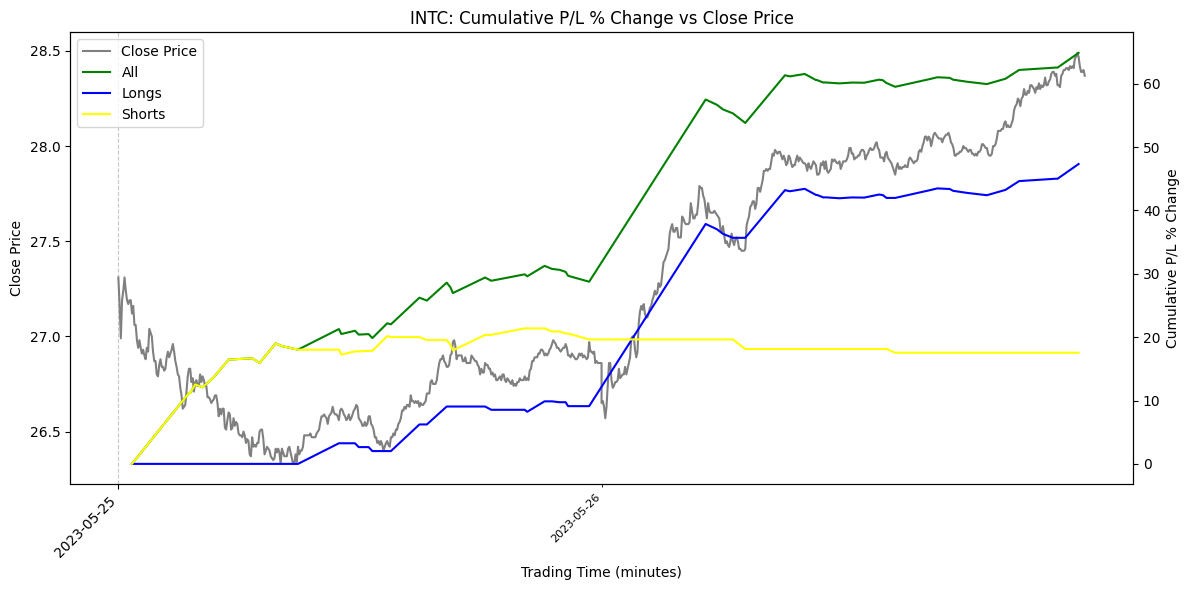

In [677]:
# soft_start_time = None
# # soft_start_time = '10:30'
# soft_end_time = '15:50'
# # soft_end_time  = None
# # soft_end_time = sell

do_longs=True
do_shorts=True

# sim_longs=True
# sim_shorts=True

# backtest_strategy( touch_detection_areas, use_margin=True, do_longs=do_longs, do_shorts=do_shorts, sim_longs=sim_longs, sim_shorts=sim_shorts, times_buying_power=4, \
#     min_stop_dist_relative_change_for_partial=0, soft_start_time=soft_start_time, soft_end_time=soft_end_time, export_trades_path='trades_output.csv')



params = StrategyParameters(
    initial_investment=10_000,
    do_longs=True,
    do_shorts=True,
    sim_longs=True,
    sim_shorts=True,
    
    use_margin=True,
    
    times_buying_power=4,
    
    soft_start_time = None, 
    soft_end_time = '15:50',
    
    # slippage_factor=0
)

strategy = TradingStrategy(TouchDetectionAreas.from_dict(touch_detection_areas), params, export_trades_path='trades_output.csv')
results = strategy.run_backtest()



In [696]:
from IPython.utils import io
results_list = []
for i in tqdm(list(np.arange(0.2, 4.01, 0.2))):
    with io.capture_output() as captured:
        params.times_buying_power = i
        balance, longs_executed, shorts_executed, balance_change, mean_profit_loss_pct, win_mean_profit_loss_pct, lose_mean_profit_loss_pct, winrate, total_costs, \
            avg_sub_pos, avg_transact, count_entry_adjust, count_entry_skip, count_exit_adjust, count_exit_skip, key_stats = \
            TradingStrategy(TouchDetectionAreas.from_dict(touch_detection_areas), params).run_backtest()

    trades_executed = longs_executed + shorts_executed
    newrow = {
        'xBP': i,
        'net%': balance_change,
        'balance': balance,
        'cnt': trades_executed,
        # 'AvgPL%': mean_profit_loss_pct,
        # 'winAvgPL%': win_mean_profit_loss_pct,
        # 'loseAvgPL%': lose_mean_profit_loss_pct,
        'WR%': winrate,
        'TotalCosts': total_costs,
        # 'avg sub pos created': avg_sub_pos,
        # 'avg transactions': avg_transact,
        'entryAdjust': count_entry_adjust,
        'entrySkip': count_entry_skip,
        'exitAdjust': count_exit_adjust,
        'exitSkip': count_exit_skip,
        **key_stats
    }
    results_list.append(newrow)

results = pd.DataFrame(results_list)
# Format specific columns if needed
results['xBP'] = results['xBP'].map('{:.1f}'.format)
results['balance'] = results['balance'].map('${:.4f}'.format)
results['TotalCosts'] = results['TotalCosts'].map('${:.4f}'.format)

# Format all float columns
float_columns = results.select_dtypes(include=['float64']).columns
results[float_columns] = results[float_columns].applymap('{:.4f}'.format)

# Display the results
pd.set_option('display.max_columns', None)
results.to_csv(f'times_buying_power_tests/{symbol}_times_buying_power_test_{start_date.split()[0]}_{end_date.split()[0]}.csv',index=False)
results

100%|██████████| 20/20 [00:12<00:00,  1.63it/s]
C:\Users\alexw\AppData\Local\Temp\ipykernel_9436\3474397858.py:39: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results[float_columns] = results[float_columns].applymap('{:.4f}'.format)


,xBP,net%,balance,cnt,WR%,TotalCosts,entryAdjust,entrySkip,exitAdjust,exitSkip,AllAvg,WinAvg,LoseAvg,LwinAvg,LwinMax,SwinAvg,SwinMax,LloseAvg,LloseMin,SloseAvg,SloseMin
0,0.2,3.6137,$10361.3666,70,37.1429,$4.2452,5,3,0,0,0.0513,0.1780,-0.0236,0.1956,1.6852,0.1500,0.5643,-0.0184,-0.0403,-0.0299,-0.0750
1,0.4,7.3101,$10731.0077,70,37.1429,$8.6566,6,1,0,0,0.1023,0.3556,-0.0473,0.3914,3.3896,0.2983,1.1201,-0.0370,-0.0813,-0.0598,-0.1496
2,0.6,11.1152,$11111.5212,70,37.1429,$13.2411,3,2,0,0,0.1532,0.5329,-0.0712,0.5862,5.0695,0.4477,1.6846,-0.0556,-0.1220,-0.0899,-0.2250
3,0.8,14.9910,$11499.1018,70,37.1429,$17.9802,6,5,0,0,0.2039,0.7098,-0.0951,0.7808,6.7473,0.5963,2.2397,-0.0743,-0.1631,-0.1201,-0.3011
4,1.0,18.9549,$11895.4896,70,37.1429,$22.8957,4,3,0,0,0.2544,0.8866,-0.1191,0.9750,8.4212,0.7452,2.8041,-0.0931,-0.2038,-0.1503,-0.3760
5,1.2,23.0338,$12303.3828,70,37.1429,$27.9819,7,5,0,0,0.3053,1.0643,-0.1431,1.1709,10.1263,0.8936,3.3635,-0.1120,-0.2445,-0.1805,-0.4516
6,1.4,27.2133,$12721.3349,70,37.1429,$33.0540,6,5,1,0,0.3556,1.2404,-0.1673,1.3643,11.7999,1.0422,3.9264,-0.1309,-0.2851,-0.2110,-0.5279
7,1.6,31.9201,$13192.0128,69,37.6812,$37.6266,9,8,4,0,0.4168,1.4167,-0.1877,1.5644,13.5045,1.1803,4.4828,-0.1500,-0.3261,-0.2354,-0.6034
8,1.8,36.1136,$13611.3551,69,37.6812,$42.5439,10,8,5,0,0.4680,1.5861,-0.2081,1.7566,15.2001,1.3134,5.0457,-0.1629,-0.4321,-0.2652,-0.6791
9,2.0,40.1125,$14011.2518,69,37.6812,$46.2263,12,10,6,0,0.5186,1.7589,-0.2314,1.9513,16.8856,1.4511,5.6022,-0.1812,-0.4786,-0.2949,-0.7543


In [639]:
# print(do_longs, do_shorts)

# from IPython.utils import io
# results_list = []
# for i in tqdm(list(np.arange(0.2, 4.01, 0.2))):

#     with io.capture_output() as captured:
#         params.times_buying_power = i

#         balance, longs_executed, shorts_executed, balance_change, mean_profit_loss_pct, win_mean_profit_loss_pct, lose_mean_profit_loss_pct, winrate, total_costs, \
#             avg_sub_pos, avg_transact, count_entry_adjust, count_entry_skip, count_exit_adjust, count_exit_skip = \
#             TradingStrategy(TouchDetectionAreas.from_dict(touch_detection_areas), params).run_backtest()

#         trades_executed = longs_executed + shorts_executed
#         newrow = {'times_buying_power':f'{i:.1f}', 'balance_pt_change':[f'{balance_change:.4f}%'], 'balance':[f'{balance:.4f}'], 'trades_executed':[trades_executed], \
#             'mean_profit_loss_pct':f'{mean_profit_loss_pct:.6f}', 'win_mean_profit_loss_pct':f'{win_mean_profit_loss_pct:.6f}', 'lose_mean_profit_loss_pct':f'{lose_mean_profit_loss_pct:.6f}',
#             'winrate':f'{winrate:.6f}', \
#             'total_costs':f'${total_costs:.4f}', \
#             'avg num sub pos created':f'{avg_sub_pos:.2f}', 'avg num transactions':f'{avg_transact:.2f}',\
#             'count_entry_adjust':f'{count_entry_adjust}', 'count_entry_skip':f'{count_entry_skip}',\
#             'count_exit_adjust':f'{count_exit_adjust}', 'count_exit_skip':f'{count_exit_skip}'}
#         results_list.append(pd.DataFrame.from_dict(newrow))

# results = pd.concat(results_list,ignore_index=True)
# results

In [640]:
plt.plot(results.times_buying_power.astype(float).to_list(), results.mean_profit_loss_pct.astype(float).to_list())

AttributeError: 'DataFrame' object has no attribute 'mean_profit_loss_pct'

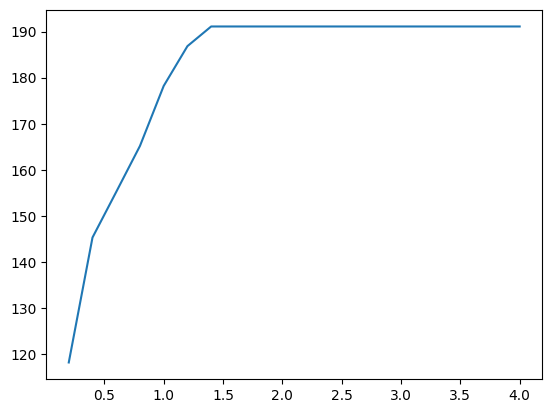

In [ ]:
plt.plot(results.times_buying_power.astype(float).to_list(), (100*(results.balance.astype(float)-10000)/10000).to_list())

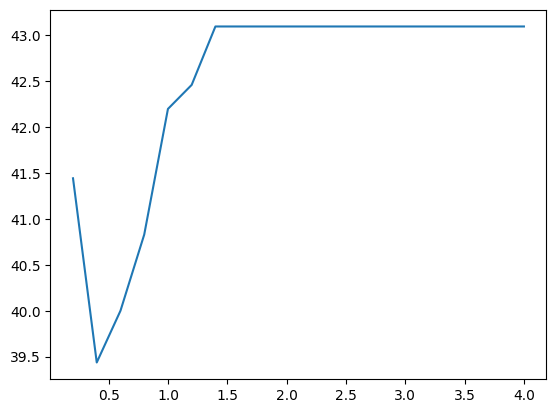

In [ ]:
plt.plot(results.times_buying_power.astype(float).to_list(), results.winrate.astype(float).to_list())

In [ ]:
# results.to_csv(f'times_buying_power_tests/{symbol}_times_buying_power_test_{start_date.split()[0]}_{end_date.split()[0]}.csv',index=False)

In [ ]:
# results.to_csv('times_buying_power_test.csv',index=False)

In [ ]:
# results.astype(float).describe()